In [15]:
import torch
import json
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import pickle
from tqdm.notebook import trange, tqdm

In [42]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) 
model = torch.load('finetuneqformer15epoch.torch')

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device);

cuda


In [4]:
f = open('questions/val_balanced_questions.json')
data = json.load(f)

In [5]:
f = open('questions/val_all_questions.json')
data_ref = json.load(f)

In [31]:
dev_val = {}
actual_questions = {}
n = 5000
for k,v in data.items():
    actual_questions[k] = v
    dev_val[k]=v
    for qid in v['entailed']:
        dev_val[qid] = data_ref[qid]
    n -= 1
    if n == 0:
        break

with open("test_finetune_questions.json", 'w') as f:
    json.dump(dev_val, f)
with open("actual_questions.json", 'w') as f:
    json.dump(actual_questions, f)

f = open('test_finetune_questions.json')
new_data = json.load(f)

In [7]:
def get_data(qid, data):
    image = data[qid]['imageId']
    question = data[qid]['question']
    answer = data[qid]['answer']
    full_answer = data[qid]['fullAnswer']
    entailed = data[qid]['entailed']
    return image, question, answer, full_answer, entailed


image, question, answer, full_answer, entailed = get_data('08223573', new_data)

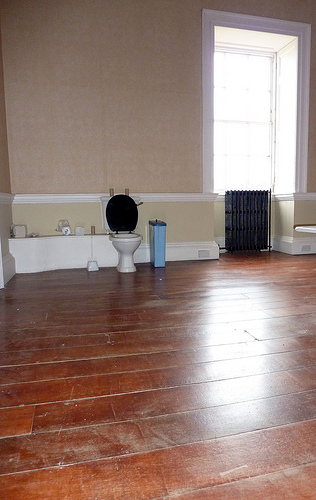

In [8]:
image = Image.open('images/'+image+'.jpg')
display(image)

In [9]:
question_formatted = f'Answer the following question with one word. Question: {question} Answer:' 
print(question_formatted)

Answer the following question with one word. Question: Is it an indoors or outdoors scene? Answer:


In [10]:
inputs = processor(image, text=question_formatted, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

outdoors


In [14]:
len(new_data)

20770

In [44]:
%%time
questions = {}
answers = {}
ground_truth = {}
# captions = {}
full_ground_truth = {}

for i, k in tqdm(enumerate(list(new_data.keys()))):
    if (i+1) % 5000 == 0:
        print(i+1)
        # dictionaries = {'questions.pkl': questions, 'answers.pkl': answers, 
        #         'ground_truth.pkl': ground_truth, 'full_ground_truth.pkl': full_ground_truth}

        # for filename, dictionary in dictionaries.items():
        #     with open(filename, 'wb') as file:
        #         pickle.dump(dictionary, file)

    if k not in questions:
        image, question, answer, full_answer, entailed = get_data(k, new_data)
    
        # entailed.append(k)
    
        image = Image.open('images/'+image+'.jpg')
        
        question_formatted = f'Answer the following question with one word. Question: {question} Answer:' 
        inputs = processor(image, text=question_formatted, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
        # inputs = processor(image, return_tensors="pt").to(device, torch.float16)
        # generated_ids = model.generate(**inputs, max_new_tokens=20)
        # caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
        answers[k] = generated_text.lower()
        questions[k] = question
        ground_truth[k] = answer
        full_ground_truth[k] = full_answer
        # print(question, generated_text.lower(), answer)
        # captions[k] = caption




0it [00:00, ?it/s]

5000
10000
15000
20000
CPU times: user 1h 36min 57s, sys: 38.8 s, total: 1h 37min 35s
Wall time: 53min 55s


In [46]:
import pickle
import json

pkl_file_path = f'{model_name}_answers.pkl'

json_file_path = f'{model_name}_val_predictions.json'

with open(pkl_file_path, 'rb') as file:
    pkl_data = pickle.load(file)

json_data = [{"questionId": key, "prediction": value} for key, value in pkl_data.items()]

with open(json_file_path, 'w') as file:
    json.dump(json_data, file, indent=4)
with open('test_finetune_questions.json', 'w') as file:
    json.dump(new_data, file, indent=4)


In [14]:
files= ['answers.pkl', 'questions.pkl', 'ground_truth.pkl', 'full_ground_truth.pkl']


for i, file in enumerate(files):
    with open(file, 'rb') as file:
        if i == 0:
            answers = pickle.load(file)
        if i == 1:
            questions = pickle.load(file)
        if i == 2:
            ground_truth = pickle.load(file)
        if i == 3:
            full_ground_truth = pickle.load(file)



In [45]:
model_name = 'finetuneqformer15'
dictionaries = {f'{model_name}_questions.pkl': questions, 
                f'{model_name}_answers.pkl': answers, 
                f'{model_name}_ground_truth.pkl': ground_truth, 
                f'{model_name}_full_ground_truth.pkl': full_ground_truth}

for filename, dictionary in dictionaries.items():
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)


In [30]:
len(new_data)

20770

In [32]:
new_data['05515936']

{'semantic': [{'operation': 'select',
   'dependencies': [],
   'argument': 'bird (329774)'},
  {'operation': 'query', 'dependencies': [0], 'argument': 'name'}],
 'entailed': ['05515938', '05515937', '05515922', '05515921'],
 'equivalent': ['05515936'],
 'question': 'Which bird is in the image?',
 'imageId': '2405722',
 'isBalanced': False,
 'groups': {'global': 'bird', 'local': '11q-bird'},
 'answer': 'parrot',
 'semanticStr': 'select: bird (329774)->query: name [0]',
 'annotations': {'answer': {'0': '329774'},
  'question': {'1': '329774'},
  'fullAnswer': {'1': '329774', '4': '329774'}},
 'types': {'detailed': 'category', 'semantic': 'cat', 'structural': 'query'},
 'fullAnswer': 'The bird is a parrot.'}

In [33]:
answers['05515936']

'parrot'

In [35]:
new_data['05515936']

{'semantic': [{'operation': 'select',
   'dependencies': [],
   'argument': 'bird (329774)'},
  {'operation': 'query', 'dependencies': [0], 'argument': 'name'}],
 'entailed': ['05515938', '05515937', '05515922', '05515921'],
 'equivalent': ['05515936'],
 'question': 'Which bird is in the image?',
 'imageId': '2405722',
 'isBalanced': False,
 'groups': {'global': 'bird', 'local': '11q-bird'},
 'answer': 'parrot',
 'semanticStr': 'select: bird (329774)->query: name [0]',
 'annotations': {'answer': {'0': '329774'},
  'question': {'1': '329774'},
  'fullAnswer': {'1': '329774', '4': '329774'}},
 'types': {'detailed': 'category', 'semantic': 'cat', 'structural': 'query'},
 'fullAnswer': 'The bird is a parrot.'}